In [1]:
from scipy.stats import median_abs_deviation

import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244/"
objdir = wdir + "quality_control/qc_objects/"

adata = sc.read_h5ad(objdir + 'msc_qc_adata.h5ad')

# Generating QC labeled, unfiltered, processed adata

- MSC starter only had enough for one 10X barcode

In [12]:
cr_outs_path = os.path.join(hdir, "mm_analysis/EXP-01244/data/EXP-01244_cr_outs")

# Dictionary mapping user-friendly sample names to their corresponding IDs
sample_dict = {
   'week2': "OR07965-01",    
   'week3': "OR07965-02", 
   'week4': "OR00001",
   'bm': "BMC07965-007",
   'msc': "CELL00911"
}

name_dict = {
   'week2': "Week 2",
   'week3': "Week 3", 
   'week4': "Week 4",
   'bm': "BMMC Start Sample",
   'msc': "MSC Start Sample"   
}

# Create reverse mapping from sample IDs to their user-friendly names
id_to_sample = {v: k for k, v in sample_dict.items()}

# Find all filtered_feature_bc_matrix.h5 files in the directory structure
h5_paths = [os.path.join(root, 'sample_filtered_feature_bc_matrix.h5') 
           for root, _, files in os.walk(cr_outs_path) 
           if 'sample_filtered_feature_bc_matrix.h5' in files]

# Get only the msc starter h5 paths
paths = [path for path in h5_paths if "CELL00911" in path]

# Dictionary to store AnnData objects for each sample
adatas = {}

# Process each H5 file
for path in paths:
    # Extract sample name from path
    name = path.split('per_sample_outs/')[1].split('/')[0]
    
    # Read the H5 file and create AnnData object
    adata = sc.read_10x_h5(path)
    adata.var_names_make_unique()

    adata.obs['sample'] = name

    adata.obs['base_sample'] = adata.obs['sample'].str.replace(r'_\d+$', '', regex=True)      # Add metadata column for batched replicates
    adata.obs['sample_type'] = adata.obs['base_sample'].replace(id_to_sample)                 # Add sample names (week2, week3, etc.)
    adata.obs['name'] = adata.obs['sample_type'].replace(name_dict)                           # Add pretty names (Week 2, Week 3, etc.)

    adatas[name] = adata.copy()

adata = ad.concat(adatas.values(), join='outer', merge='same')

adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)                # calling outlier cells with log1p_total_counts greater than 5 MAD's
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)         # calling outlier cells with log1p_n_genes_by_counts greater than 5 MAD's
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)      # calling outlier cells with pct_counts_in_top_20_genes greater than 5 MAD's
)

# Call mt outlier cells with pct_counts_mt greater than 3 MAD's
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3)

# Run Scrublet for doublet detection
scrub = scrublet.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)

# Add Scrublet results to cell metadata
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

# Store log1p transformed normalized counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Saving raw adata
adata.raw = adata

# Standard processing workflow
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.write(objdir + 'msc_qc_adata.h5ad', compression='gzip')

... storing 'sample' as categorical
... storing 'base_sample' as categorical
... storing 'sample_type' as categorical
... storing 'name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [13]:
def compute_qc(data_metric, lower_q, upper_q):
    """
    Compares and plots quality check plots for your desired input metric. 
    
    Parameters:
    data_metric (pd.Series): Input data matrix in a adata.obs['metric'] format. 
                             Example: adata.obs['total_counts']
    lower_q (float): Lower bound for quantile value
    upper_q (float): Upper bound for quantile value
    
    Outputs:
    Various statistical metrics and a histogram marking quantile marks and mean value. 
    """
    mean = np.mean(data_metric)
    median = np.median(data_metric)
    q1 = np.quantile(data_metric, lower_q)
    q2 = np.quantile(data_metric, upper_q)

    total = sum(data_metric)

    print(f"{'_' * 30}\n")
    print(f"Mean value: {mean:.2f}")
    print(f"Median value: {median:.2f}\n")
    print(f"{lower_q} Quantile value: {q1:.2f}")
    print(f"Percant of counts below {q2:.2f}: {(sum(data_metric < q1)/total) * 100:.2f}%")
    print(f"Counts below {q1:.2f}: {sum(data_metric < q1)}\n")
    print(f"{upper_q} Quantile value: {q2:.2f}")
    print(f"Percant of counts above {q2:.2f}: {(sum(data_metric > q2)/total) * 100:.2f}%")
    print(f"Counts above {q2:.2f}: {sum(data_metric > q2)}\n")
    print(f"{'_' * 30}\n")
    
    plt.figure(figsize=(8,4), dpi=60, facecolor='w', edgecolor='k') 
    sns.histplot(data_metric, bins=100)
    plt.axvline(median, color='yellow', label='Mean')
    plt.axvline(q1, color='red', label=f'{lower_q} Quantile')
    plt.axvline(q2, color='red', label=f'{upper_q} Quantile')
    plt.legend()
    plt.show()

______________________________

Mean value: 0.73
Median value: 0.48

0.01 Quantile value: 0.00
Counts below 0.00: 0

0.95 Quantile value: 1.91
Counts above 1.91: 508

______________________________



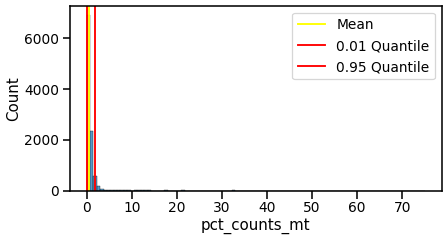

______________________________

Mean value: 0.13
Median value: 0.12

0.01 Quantile value: 0.02
Counts below 0.02: 97

0.95 Quantile value: 0.28
Counts above 0.28: 482

______________________________



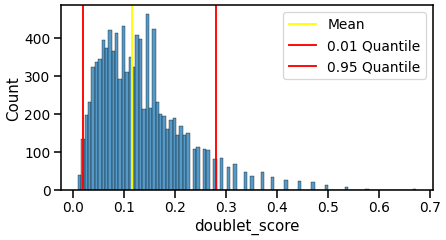

______________________________

Mean value: 9.35
Median value: 9.27

0.01 Quantile value: 6.70
Counts below 6.70: 102

0.95 Quantile value: 11.18
Counts above 11.18: 508

______________________________



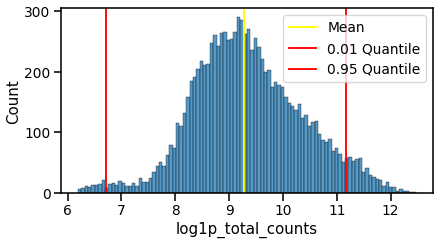

______________________________

Mean value: 8.16
Median value: 8.19

0.01 Quantile value: 6.35
Counts below 6.35: 101

0.95 Quantile value: 8.97
Counts above 8.97: 508

______________________________



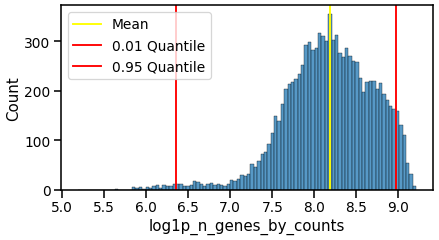

______________________________

Mean value: 19.12
Median value: 18.91

0.01 Quantile value: 12.62
Counts below 12.62: 102

0.95 Quantile value: 24.88
Counts above 24.88: 508

______________________________



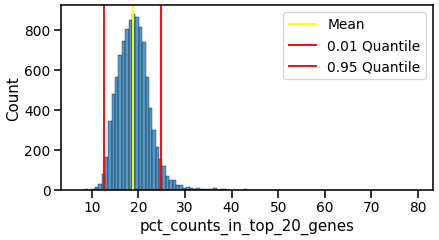

In [15]:
compute_qc(adata.obs['pct_counts_mt'], 0.01, 0.95)
compute_qc(adata.obs['doublet_score'], 0.01, 0.95)
compute_qc(adata.obs['log1p_total_counts'], 0.01, 0.95)
compute_qc(adata.obs['log1p_n_genes_by_counts'], 0.01, 0.95)
compute_qc(adata.obs['pct_counts_in_top_20_genes'], 0.01, 0.95)

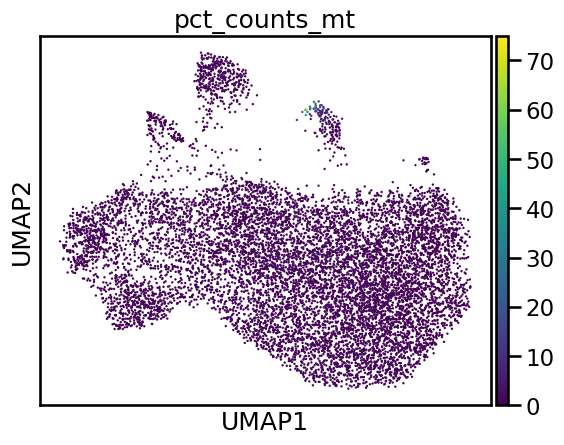

In [6]:
sc.pl.umap(msc_adata, color='pct_counts_mt')

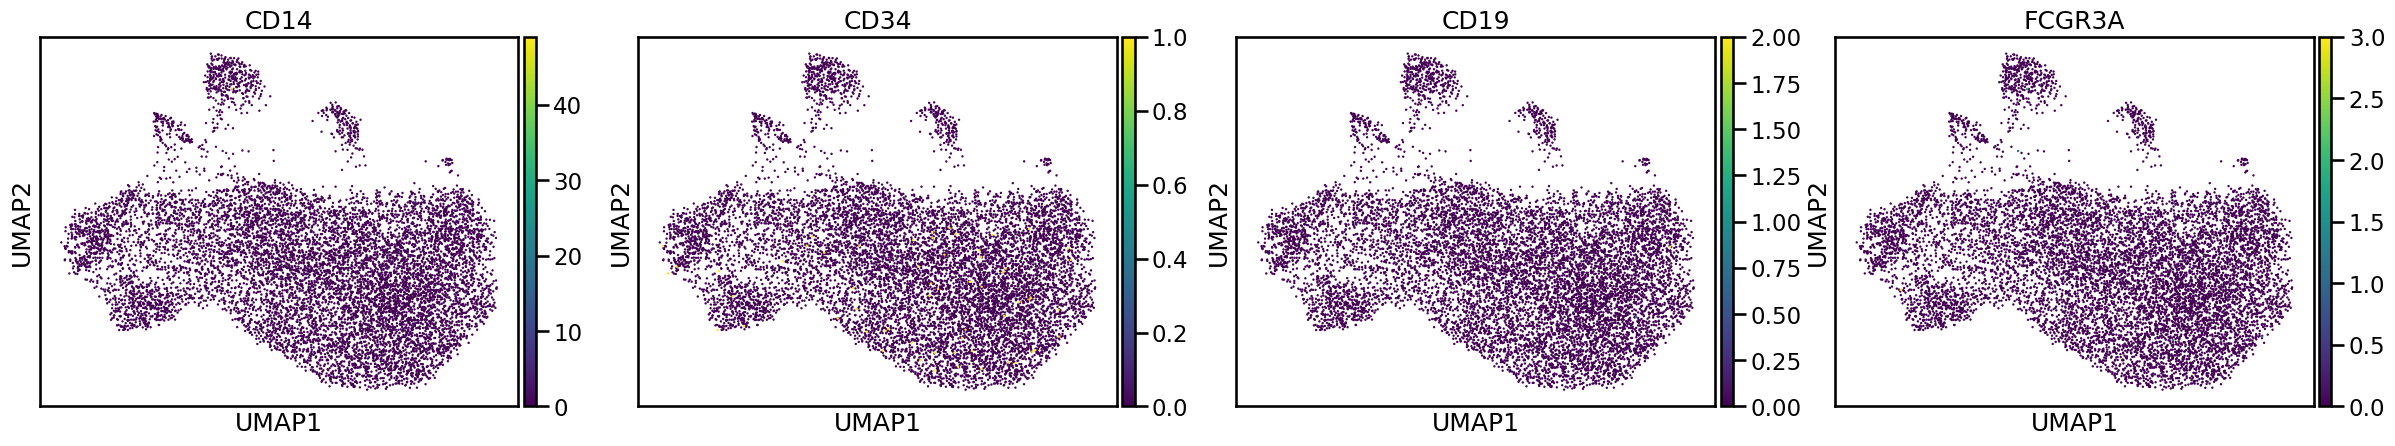

In [5]:
sc.pl.umap(msc_adata, color=['CD14', 'CD34', 'CD19', 'FCGR3A'])

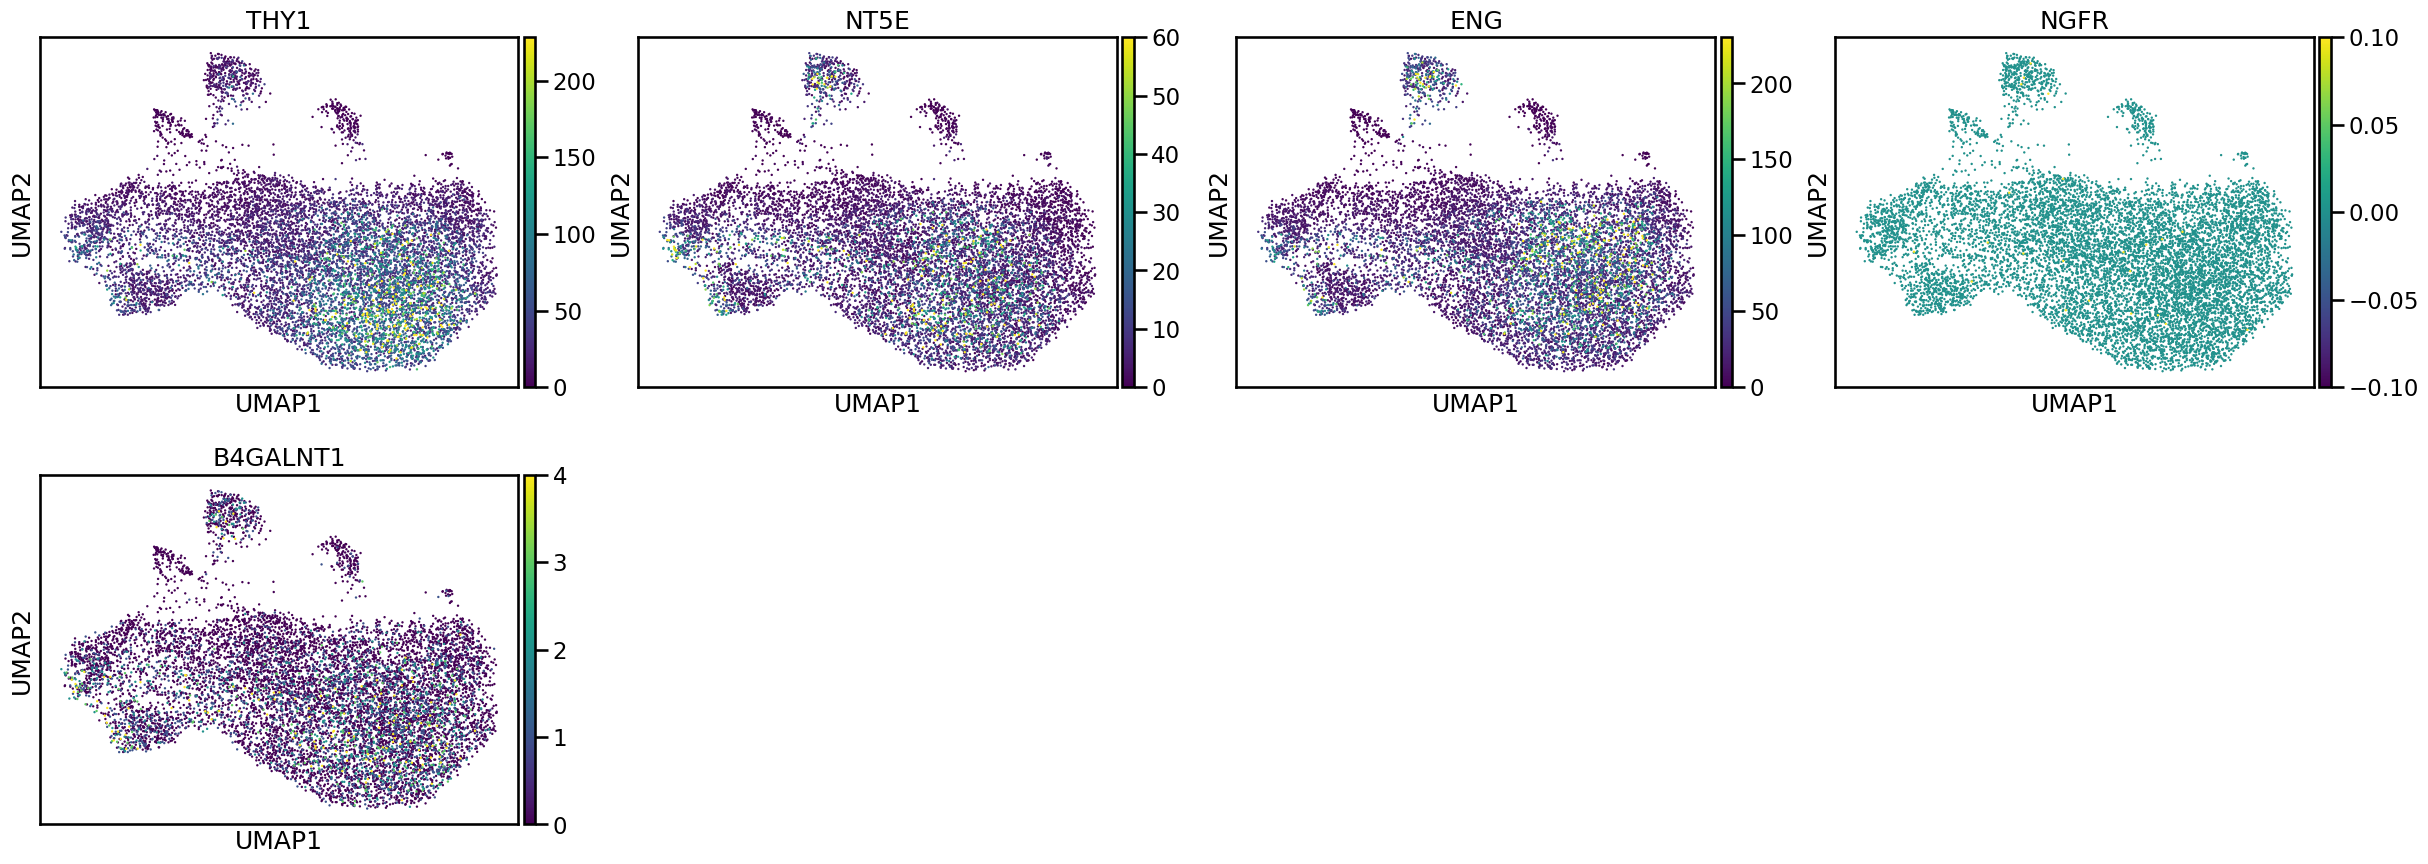

In [10]:
genes = ["THY1", "NT5E", "ENG", "NGFR", "B4GALNT1"]
sc.pl.umap(msc_adata, color=genes, vmax='p99')